In [1]:
# Import required modules
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import train and test datasets
train_df = pd.read_csv('train_auto.csv')
test_df  = pd.read_csv('test_auto.csv')

### 1- Data Exploration

#### See the HTML file data_exploration_report

In [3]:
# Generate Report Using Pandas Profiling (Variables types,descriptions and distributions, missing values, correlations, ...)
train_data_profile = ProfileReport(train_df)
# Save profile to an HTML
train_data_profile.to_file("data_exploration_report.html")

### 2- Data Wrangling / Cleaning

In [4]:
# Remove unneeded columns
# The target amount is supposed to be among the target variables, so we will remove it.
# The home value is not supposed to have an impact on the car expected claims.
# Owning a red car means having higher premiums is a myth with no research or statistics to back it up.
# Having a red car will not have any effect on any part of the insurance. Thus we will remove this column.

to_drop = ['INDEX', 
           'TARGET_AMT',
           'HOME_VAL',
           'RED_CAR']
train_df.drop(to_drop, inplace=True, axis=1)
test_df.drop(to_drop, inplace=True, axis=1)

In [5]:
# Fix structural errors
# Remove the '$' and ',' symbols from the amount values in the columns 'INCOME','BLUEBOOK' and 'OLDCLAIM' supposed to be numerical.
train_df[['INCOME', 'BLUEBOOK', 'OLDCLAIM']] = train_df[['INCOME', 'BLUEBOOK', 'OLDCLAIM']].replace({'\$': '', ',': ''}, regex=True).astype(float)
test_df[['INCOME', 'BLUEBOOK', 'OLDCLAIM']] = test_df[['INCOME', 'BLUEBOOK', 'OLDCLAIM']].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Remove the '<' symbol from the 'EDUCATION' column
train_df['EDUCATION'] = train_df['EDUCATION'].replace({'<': 'lower than '}, regex=True)
test_df['EDUCATION'] = test_df['EDUCATION'].replace({'<': 'lower than '}, regex=True)

# Remove 'z_' from the categorical columns
CAT_COL = ['PARENT1','MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'CAR_USE', 'CAR_TYPE', 'REVOKED', 'URBANICITY']
train_df[CAT_COL] = train_df[CAT_COL].replace({'z_': ''}, regex=True)
test_df[CAT_COL]  = test_df[CAT_COL].replace({'z_': ''}, regex=True)

In [6]:
# Remove missing values
# We have a small percentage of missing cells (1.1% in total) for the following columns (see pandas profiling report above for details) : 
                # AGE (0.7%)
                # YOJ (0.3%)
                # INCOME (5.5%)
                # JOB (4.6%)
                # CAR_AGE (6.2%)
# We will use the median imputation and use the train median of columns to impute both train and test missing values.
train_df = train_df.fillna(train_df.median())
test_df  = test_df.fillna(train_df.median())

### 3- Feature Engineering

In [7]:
# Log transform of the INCOME column
# This transformation will help to handle skewed data and decreases the impact of the outliers.
train_df['LOG_INCOME'] = (train_df['INCOME'] + 1).transform(np.log)
train_df.drop(['INCOME'], inplace=True, axis=1)
test_df['LOG_INCOME']  = (test_df['INCOME'] + 1).transform(np.log)
test_df.drop(['INCOME'], inplace=True, axis=1)

In [8]:
# One hot encoding for categorical variables
train_df = pd.get_dummies(train_df)
test_df  = pd.get_dummies(test_df)

### 4- Modeling

##### - The prediction of the claims is intended to predict if the insured will file a claim or not. TARGET_FLAG = {0,1} is our target, with 0,1 being categorical values that reflect that the client ‘will not file a claim’ or ‘will file a claim’, respectively.
##### - The purpose of our machine learning model is to predict the probability of claim occurrence. This algorithm is modeled on data representing a customer that has made a claim or not made a claim. Therefore, the problem can be identified as a binary classification, where a claim is a 1 and no claim made is a 0.
##### - Different classification algorithms can be used in our case. We will test Logistic regression, Decision Tree, XGBoost and Random Forest in order to find the one with better performance. Grid searches will be conducted to find hyper-parameters that would yield optimal performance for the models
##### - Though, it is important to mention that our data is imbalanced with a mild degree (not very problematic). Majority Class is class 0 with no claims (74%), minority class is class 1 with claims (26%) We will first try training on the true distribution. If the model works well and generalizes, we're done! If not, we will try the downsampling or upweighting technique.

In [9]:
# Split train and test datasets into features and target variable
X = train_df.drop(['TARGET_FLAG'], axis=1)# Features
y = train_df.TARGET_FLAG # Target variable

X_test = test_df.drop(['TARGET_FLAG'], axis=1)# Features
y_test = test_df.TARGET_FLAG # Target variable

In [10]:
# Split X and y into training and evaluation sets
X_train,X_eval,y_train,y_eval=train_test_split(X,y,test_size=0.25,random_state=0)

#### 4.1- Logistic Regression

##### For the binary-dependent variables, logistic regression (LR) is a suitable model for evaluating regression. LR is a statistical analysis used to describe how a binary target variable is connected to various independent features.

In [11]:
# Instantiate the model(using the default parameters)
logreg = LogisticRegression(solver='liblinear')
# Fit the model with data
logreg.fit(X_train,y_train)
# Perform prediction on the eval set
y_pred_logreg=logreg.predict(X_eval)

#### 4.2- Decision Tree

##### A decision tree is a supervised learning approach used to solve classification and regression issues, but it is mostly used to solve classification issues. It is a classifier organized by the tree structure, where the internal nodes are the data variables, the branches are the decision rules, and each node is the output.

In [12]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

In [13]:
# Hyperparameters Tuning
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
# Train Decision Tree Classifer
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.8s finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [14]:
clf_best = grid_search.best_estimator_
# Perform prediction on the eval set
y_pred_clf_best = clf_best.predict(X_eval)

#### 4.3- XGBoost

##### XGBoost is a novel approach proposed to raise the gradient tree. It uses various decision trees to predict a result. XGBoost stands for extreme gradient boosting. A regression and classification problem learning technique optimizes a series of weak prediction models to construct a precise and accurate predictor. It is a desirable model, because it can boost weak learners. Furthermore, it can improve the insurance risk classifier’s performance by combining multiple models. Some studies showed that the XGBoost model is the best model for the prediction of claims occurrence with a small dataset (Pesantez-Narvaez et al. 2019).

In [15]:
# Instantiate an XGBoost classifier object
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1)

In [16]:
# Hyperparameters Tuning
# A parameter grid for XGBoost
param_grid = {
        'min_child_weight': [1, 3],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 4, 5]
        }
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb,
                           param_grid = param_grid,                        
                           cv = 4,
                           n_jobs = -1,
                           verbose = 1)
# Fit the grid search to the data
grid_search.fit(X_train,y_train)
grid_search.best_estimator_

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.5min finished


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=None)

In [17]:
xgb_best = grid_search.best_estimator_
# Perform prediction on the eval set
y_pred_xgb_best = xgb_best.predict(X_eval)

#### 4.4- Random Forests

##### Random forests reflect a shift to the bagged decision trees that create a broad number of de-correlated trees so that predictive efficiency can be improved further. They are a very popular“off-the-shelf” learning algorithm with good predictive performance and relatively few hyper-parameters.

In [18]:
# Create a based model
rfc=RandomForestClassifier()

In [19]:
# Hyperparameters Tuning
# Create the parameter grid based on the results of random search 
param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train,y_train)
grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:    3.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    4.1s finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
rfc_best = grid_search.best_estimator_
# Perform prediction on the eval set
y_pred_rfc_best = rfc_best.predict(X_eval)

### 5- Models Evaluation (Performance Prediction )

##### There are several metrics to evaluate a classifier model and examine how well the model fits a dataset and its performance on the unseen data.
##### Accuracy alone for a classification problem cannot always be reliable, because it can provide bias for a majority class giving high accuracy and weak accuracy for the minority class, making it less informative for predictions, especially in the case of imbalanced data.
##### Car insurance claims are an excellent example of imbalanced data, because the majority of policyholders do not make a claim. Therefore, if accuracy is used, there would be a bias toward a no claim class. 
##### Thus, we will use other measures, such confusion matrix, precision, recall, F1-score, and AUC

In [21]:
# Confusion Matrix 
# Visualize the results of the model in the form of a confusion matrix using matplotlib and seaborn.
def confusion_matrix_plot(y_eval, y_pred):
    cnf_matrix = metrics.confusion_matrix(y_eval, y_pred)
    sensitivity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
    print('Sensitivity : ', sensitivity)
    specificity = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
    print('Specificity : ', specificity)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [22]:
# Confusion Matrix Evaluation Metrics
# Evaluate the model using model evaluation metrics such as accuracy, precision,recall and F1_score.
def evaluation_metrics(y_eval, y_pred):
    print("Accuracy:",metrics.accuracy_score(y_eval, y_pred))
    print("Precision:",metrics.precision_score(y_eval, y_pred))
    print("Recall:",metrics.recall_score(y_eval, y_pred))
    print("F1_score:",metrics.f1_score(y_eval, y_pred))

In [23]:
# ROC Curve
# Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. 
# It shows the tradeoff between sensitivity and specificity.
def roc_curve_plot(y_pred_proba, y_eval):
    fpr, tpr, _ = metrics.roc_curve(y_eval,  y_pred_proba)
    auc = metrics.roc_auc_score(y_eval, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

In [24]:
print('LOGISTIC REGRESSION')
evaluation_metrics(y_eval, y_pred_logreg)
print('--------------------------------')
print('DECISION TREE BEST')
evaluation_metrics(y_eval, y_pred_clf_best)
print('--------------------------------')
print('XGBOOST')
evaluation_metrics(y_eval, y_pred_xgb_best)
print('--------------------------------')
print('RANDOM FOREST')
evaluation_metrics(y_eval, y_pred_rfc_best)

LOGISTIC REGRESSION
Accuracy: 0.7829495345418912
Precision: 0.6408668730650154
Recall: 0.38764044943820225
F1_score: 0.4830805134189031
--------------------------------
DECISION TREE BEST
Accuracy: 0.7569818716315532
Precision: 0.6
Recall: 0.21348314606741572
F1_score: 0.3149171270718232
--------------------------------
XGBOOST
Accuracy: 0.7966682998530132
Precision: 0.663013698630137
Recall: 0.45318352059925093
F1_score: 0.5383759733036707
--------------------------------
RANDOM FOREST
Accuracy: 0.7814796668299853
Precision: 0.6235955056179775
Recall: 0.4157303370786517
F1_score: 0.49887640449438203


LOGISTIC REGRESSION
Sensitivity :  0.9230258792302588
Specificity :  0.38764044943820225


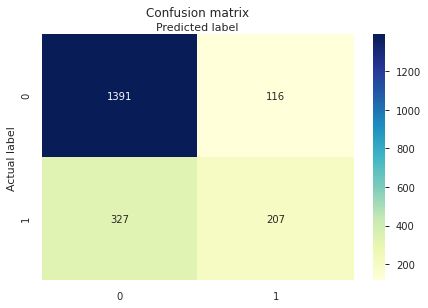

DECISION TREE
Sensitivity :  0.9495686794956868
Specificity :  0.21348314606741572


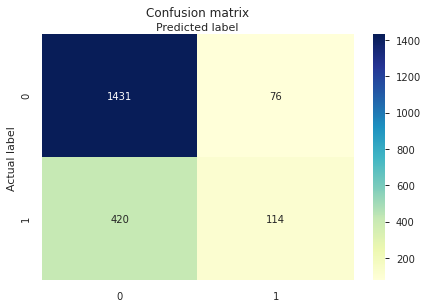

XGBOOST
Sensitivity :  0.9183808891838089
Specificity :  0.45318352059925093


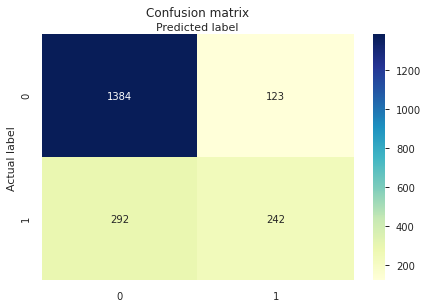

RANDOM FOREST
Sensitivity :  0.9110816191108162
Specificity :  0.4157303370786517


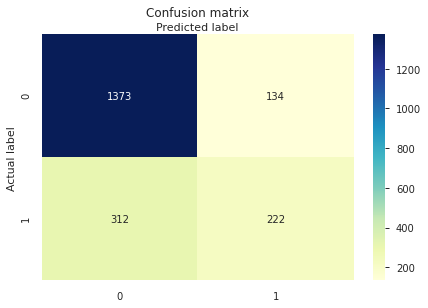

In [25]:
print('LOGISTIC REGRESSION')
confusion_matrix_plot(y_eval, y_pred_logreg)
print('DECISION TREE')
confusion_matrix_plot(y_eval, y_pred_clf_best)
print('XGBOOST')
confusion_matrix_plot(y_eval, y_pred_xgb_best)
print('RANDOM FOREST')
confusion_matrix_plot(y_eval, y_pred_rfc_best)

LOGISTIC REGRESSION


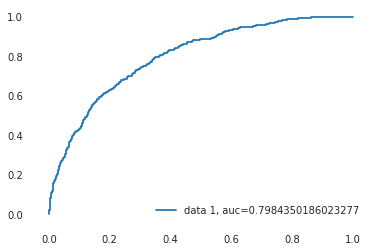

DECISION TREE


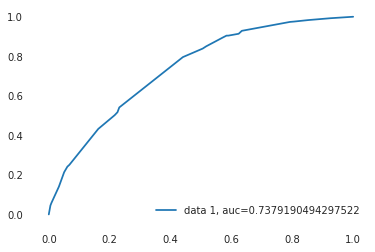

XGBOOST


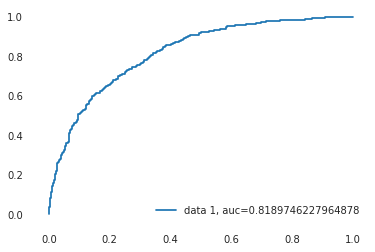

RANDOM FOREST


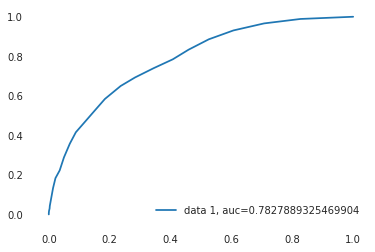

In [26]:
print('LOGISTIC REGRESSION')
y_pred_logreg_proba = logreg.predict_proba(X_eval)[::,1]
roc_curve_plot(y_pred_logreg_proba, y_eval)
print('DECISION TREE')
y_pred_clf_best_proba = clf_best.predict_proba(X_eval)[::,1]
roc_curve_plot(y_pred_clf_best_proba, y_eval)
print('XGBOOST')
y_pred_xgb_best_proba = xgb_best.predict_proba(X_eval)[::,1]
roc_curve_plot(y_pred_xgb_best_proba, y_eval)
print('RANDOM FOREST')
y_pred_rfc_best_proba = rfc_best.predict_proba(X_eval)[::,1]
roc_curve_plot(y_pred_rfc_best_proba, y_eval)

#### Every model  was evaluated according to a confusion matrix, precision, recall, F1-score, and AUC. Then, we compared all classifier models and we selected the XGBoost model as the best classifier.
#### The range of accuracy values for all ML models was between 75.69% and 79.47%. XGBoost was the best model, with a high accuracy of 79.47% . The results showed that XGBoost was most likely to solve claim prediction problems correctly.
#### XGBoost had the highest Specificity, which means that 45% of the true negative samples were correctly classified. The Sensitivity for the XGBoost model explains that 97.16% of the samples detected as positive were actually positive. It has also the highest F1 score 53%.
#### Based on the AUC comparison of the classifiers, the XGBoost score was 0.818, which was the best.

### 6- Prediction on the test set

In [27]:
def save_predictions(model, X_test) :
    y_pred_xgb_best_test = model.predict(X_test)
    predictions = pd.DataFrame(y_pred_xgb_best_test)
    test_df  = pd.read_csv('test_auto.csv')
    predictions.index = test_df.INDEX # for comparison
    predictions.columns = ["TARGET_FLAG"]
    predictions.to_csv("prediction_results.csv")

In [28]:
save_predictions(xgb_best, X_test)